In [2]:
%matplotlib inline

import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import seaborn
plt.rcParams['axes.labelsize'] = 22

/home/greg/Programs/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# The relation between priors and the evidence

I wanted to understand a bit more about the effect of priors on so-called evidence. To be specific let's imagine we have a single data point $d=5$ and take a fixed likelihood function of a normal:

$$\mathcal{L}(d=5| \mu, \sigma) = N(5; \mu, \sigma) $$

Now the *evidence* is given by marginalising the likelihood and prior ($\pi$) over the parameters $\mu$ and $\sigma$:

$$ Z = \int \mathcal{L}(d=5| \mu, \sigma) \pi(\mu, \sigma) d\mu d\sigma $$

To simplify things, we will fix $\sigma=1$. Then all that remains is to specify the *prior* distribution on $\mu$.

## Uniform prior

The typical case is to set $\pi(\mu)$ to be uniform over some range $[a, b]$ e.g.

$$\pi(\mu) = \left\{ \begin{array}{cc} 1/(b-a) & \textrm{if } a < \mu < b \\ 0 & \textrm{otherwise} \end{array}\right. $$

Inserting a uniform prior along with our normal likelihood (with $\sigma=1$) then calculating the evidence consists of evaluating:

$$ Z = \frac{1}{b-a}\int_{a}^{b} N(5; \mu, 1) d\mu $$

Now provided the region $[a, b]$ contains most of the probability (e.g. the normal likelihood has decayed to near-zero at $a$ and $b$), then the integral is approximately unity. This leaves

$$ Z = \frac{1}{b-a} $$

## Checking the result

Now we introduce a helper function `run` with which we can calculate the posterior and evidence. We will be using [emcee](http://dan.iel.fm/emcee/current/) for the MCMC simulations and in particular the `ptsampler` so that we can use [thermodynamic integration](http://dan.iel.fm/emcee/current/user/pt/) to calculate the evidence. The function `run` can take both uniform and normal priors which we will discuss later. For now ignore the following cell...  

In [3]:
def run(prior_type, x1, x2, plot=True, x=[5.0], betamin=-3, ntemps=30):

    if prior_type == "norm":
        def logp(mu):
            return -(mu - x1)**2 / (2*x2**2) - np.log(x2*np.sqrt(2*np.pi))
    elif prior_type == "unif":
        def logp(mu):
            if x1 < mu and mu < x2:
                return -np.log(x2 - x1)
            else:
                return -np.inf
            
    def logl(params):
        sigma = 1
        mu = params
        single = -(x-mu)**2 / (2*sigma**2) - np.log(sigma*np.sqrt(2*np.pi))
        return np.sum(single)

    nwalkers = 50
    ndim = 1
    betas = np.logspace(0, betamin, ntemps)
    sampler = emcee.PTSampler(ntemps, nwalkers, ndim, logl=logl, logp=logp,
                              betas=betas)
    p0 = np.random.uniform(4, 6, size=(ntemps, nwalkers, ndim))
    out = sampler.run_mcmc(p0, 200)
 
    ln_evidence, ln_error = sampler.thermodynamic_integration_log_evidence()
    evidence = np.exp(ln_evidence)
    error = np.exp(ln_evidence) * ln_error
    
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 6))
        ax1.plot(sampler.chain[0, :, :, 0].T, color="k", lw=0.1)
        ax1.set_ylabel("Walker positions for $\mu$")
        ax1.set_xlabel("Simulation step")
        
        nburn=100
        samples = sampler.chain[0, :, nburn:, :].reshape((-1, ndim))

        xplot = np.linspace(0, 10, 100)
        prior = [np.exp(logp(xi)) for xi in xplot]
        ax2.plot(xplot, prior, label="prior")
        ax2.hist(samples, bins=50, histtype="step", normed=True,
                 label="posterior", color="k", linewidth=2)
        for xi in x[:-1]:
            ax2.axvline(xi, color="r", lw=0.5)
        ax2.axvline(xi, color="r", lw=1.0, label="data point")
        ax2.legend(frameon=False, loc="best")
        ax2.set_xlabel("$\mu$ posterior")
        
        mean_lnlikes = np.mean(np.mean(sampler.lnlikelihood, axis=1), axis=1)
        betas = sampler.betas
        ax3.semilogx(betas, mean_lnlikes, "-o")
        ax3.set_xlabel(r"$\beta$")
        ax3.set_ylabel("Mean likelihood")
        plt.tight_layout()
        plt.show()
        
        if abs(np.log10(evidence)) < 3:
            print "Z = {:1.4f} +/- {:1.4f}".format(
            evidence, error)
        else:
            print "Z = {:1.3e} +/- {:1.3e}".format(
            evidence, error)
    else:  
        return evidence, error

### Example

Okay now let's fix our prior volume as $[a, b] = [0, 10]$ so we should find $Z = 0.1$. We will run the simulation with such a uniform prior and let's have a look at the results: 

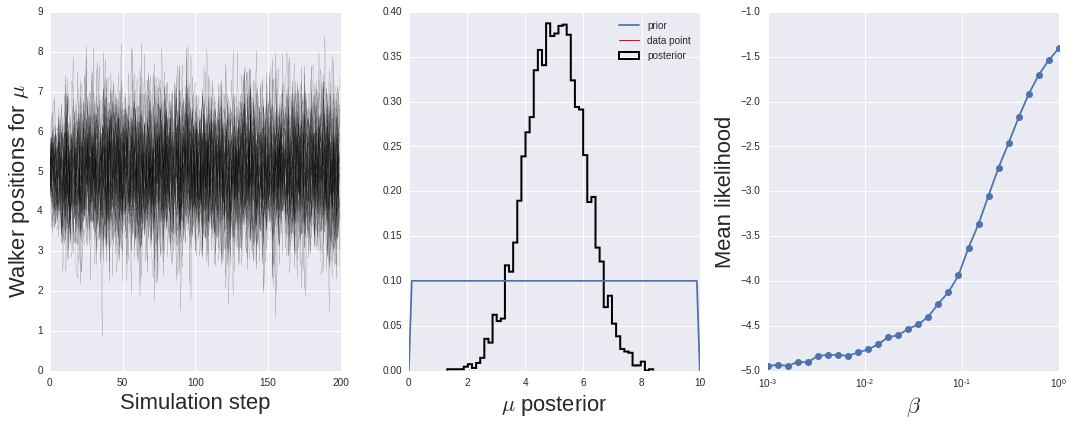

Z = 0.1095 +/- 0.0098


In [4]:
run('unif', 0, 10)

### A little explanation:

`run` produces 3 plots: the first is the direct results of the simulations, the second is the estimated posterior along with the data point and prior, finaly there is a plot of the mean likelihood used to estimate the evidence.

In essence you can ignore the first and last plots and focus on the posterior and the evidence quoted at the bottom.

### Back to buisness

Okay so as expected we get $Z = 0.1$ and a posterior centered on the data point. In addition the posterior is zero at 0 and 10 so we should expect agreement with the analytic result. Excellent!

### Breaking the result

Just for fun, let's set $[a, b]$ = [4, 6] so, according to the analytic result, we should get $Z = 1/2$. But, because the likelihood is still finite at the edges of the prior volume this is not the case.

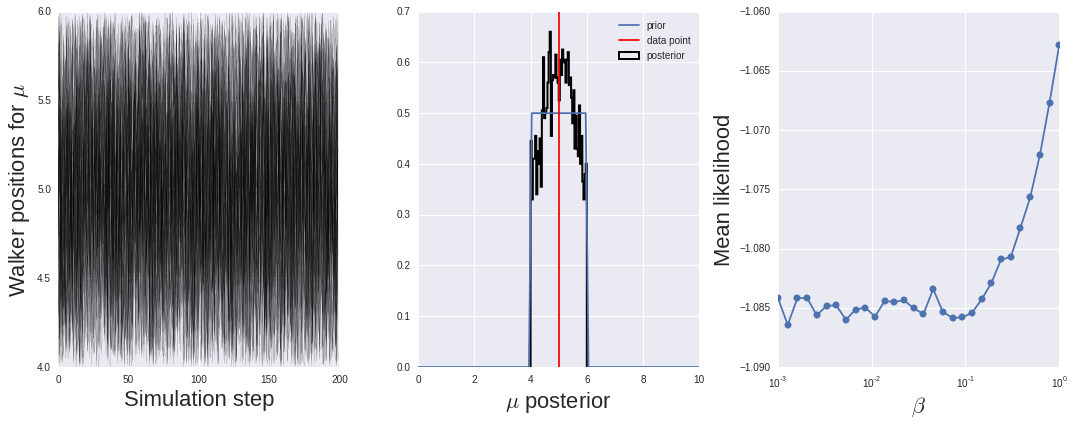

Z = 0.3417 +/- 0.0001


In [4]:
run('unif', 4, 6)

## Gaussian Prior

Okay now that we are confident that `run` does what it should (computes Z), let's use it with a prior that we can't easily do analytically.  Note that the last two arguments to `run` are the `loc` and `scale` of the normal in that order:

### Informative Gaussian prior

Let's try an informative prior: a Gaussian centered on 5 with a small scale parameter

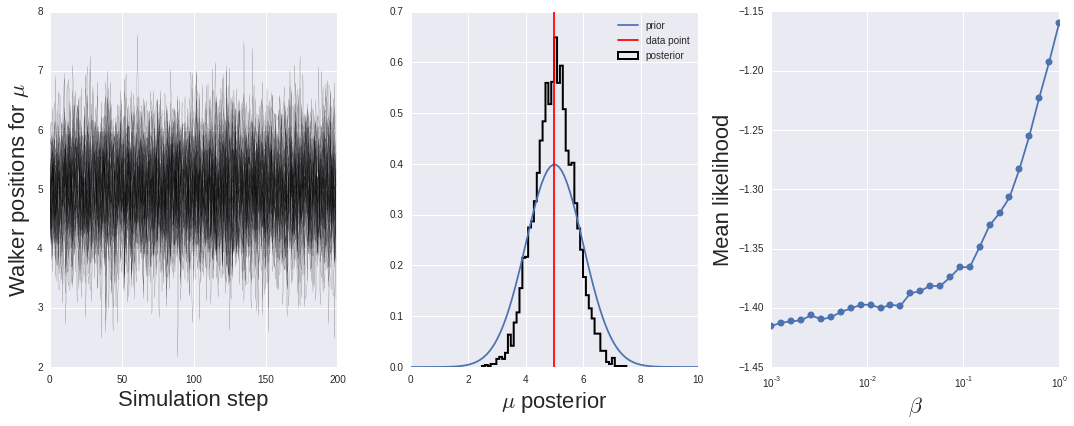

Z = 0.2827 +/- 0.0000


In [5]:
run('norm', 5, 1)

### Non-informative Gaussian prior

A typical way to make Gaussians non-informative is to set a large scale parameter (where large is in relation to the size of the mean).

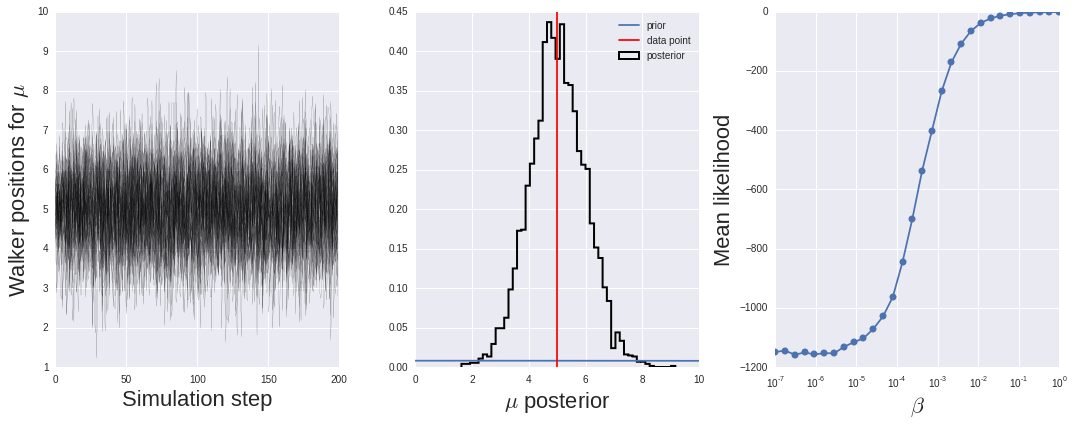

Z = 0.0071 +/- 0.0036


In [6]:
run('norm', 0, 50, betamin=-7)

### Mis-informative Gaussian prior

Now let's consider a prior which is informative, but does not support the data. To be specific we will use a normal prior for $\mu$ with mean at 2.5 and a relatively small scale factor:

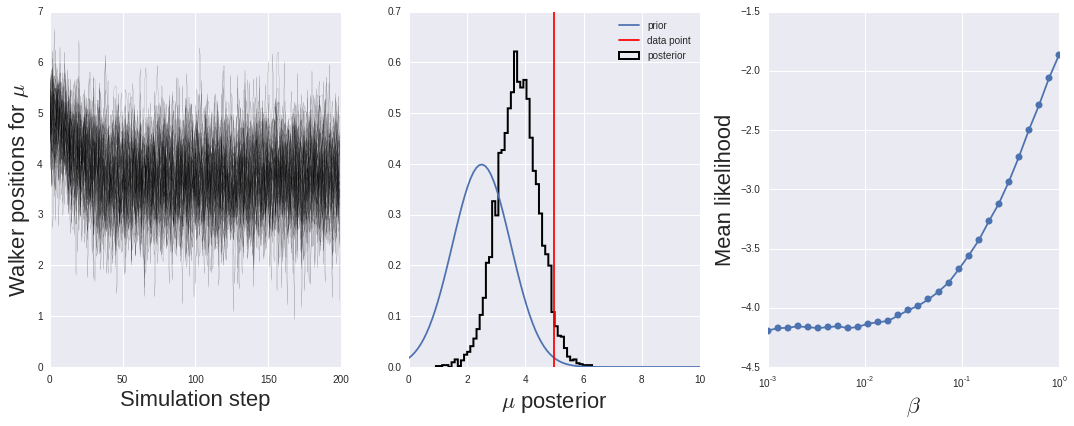

Z = 0.0629 +/- 0.0009


In [7]:
run('norm', 2.5, 1.0)

The posterior sits half way between the data point and the prior. The evidence is substantially weakened (by an order of magnitude) when compared to the informative Gaussian.

### Plotting the evidence as a function of the mean

Let's fix the prior variance on $\mu$ at 1 and vary the mean then look at how this changes the evidence

In [8]:
mu_mean = np.linspace(-5, 15, 50)
Z = []
Zerr = []
for mm in mu_mean:
    evi, err = run('norm', mm, 1.0, plot=False) 
    Z.append(evi)
    Zerr.append(err)

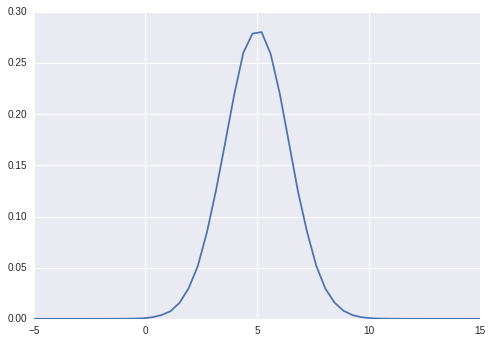

In [9]:
from scipy.stats import norm
fig, ax = plt.subplots()
ax.plot(mu_mean, Z, "-")
plt.show()

## Multiple data points

A reasonable extension is to consider extra data points

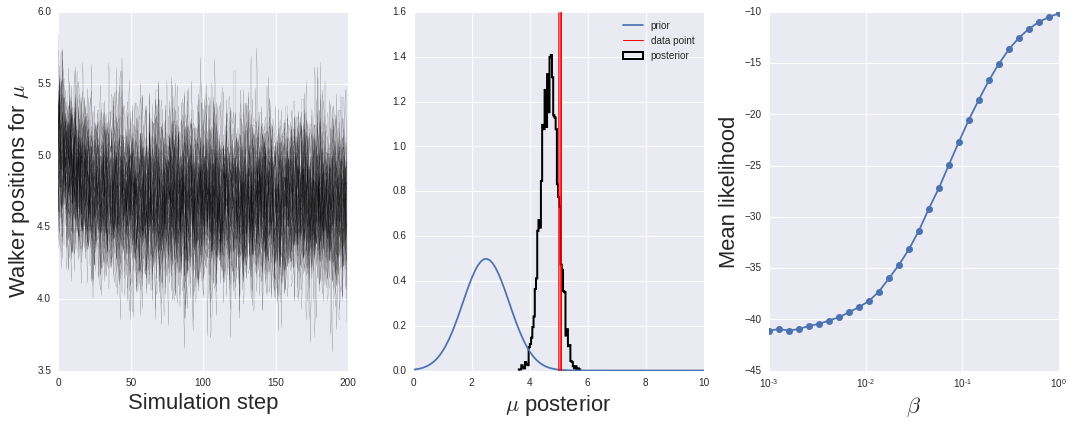

Z = 8.620e-07 +/- 3.549e-07


In [5]:
run('norm', 2.5, 0.8, x=np.random.normal(5, 0.1, 10))

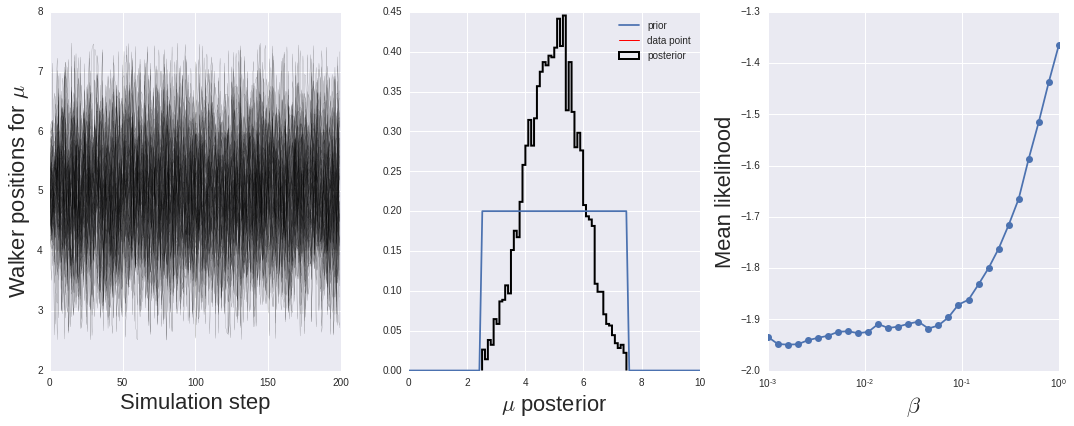

Z = 0.2036 +/- 0.0053


In [11]:
run('unif', 2.5, 7.5, x=np.random.normal(5, 0.1, 1))

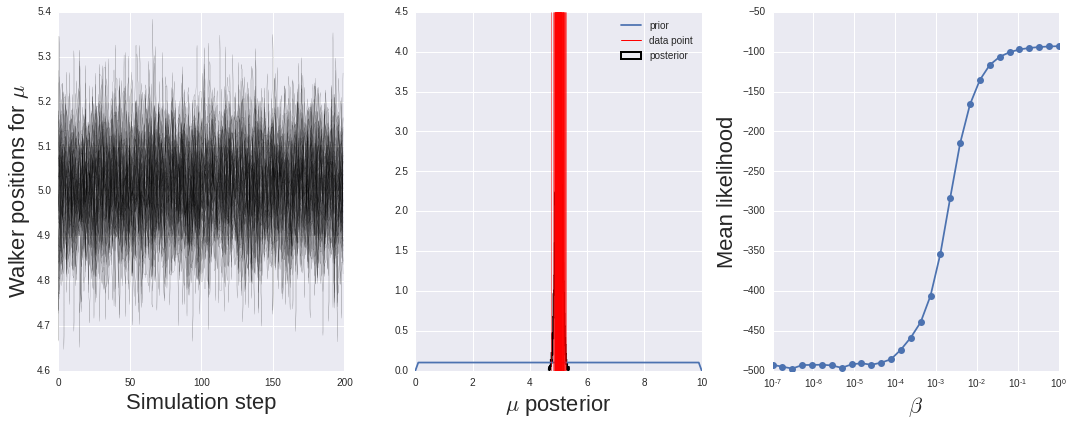

Z = 4.098e-42 +/- 2.212e-42


In [18]:
run('unif', 0, 10.0, x=np.random.normal(5, 0.1, 100), betamin=-7)

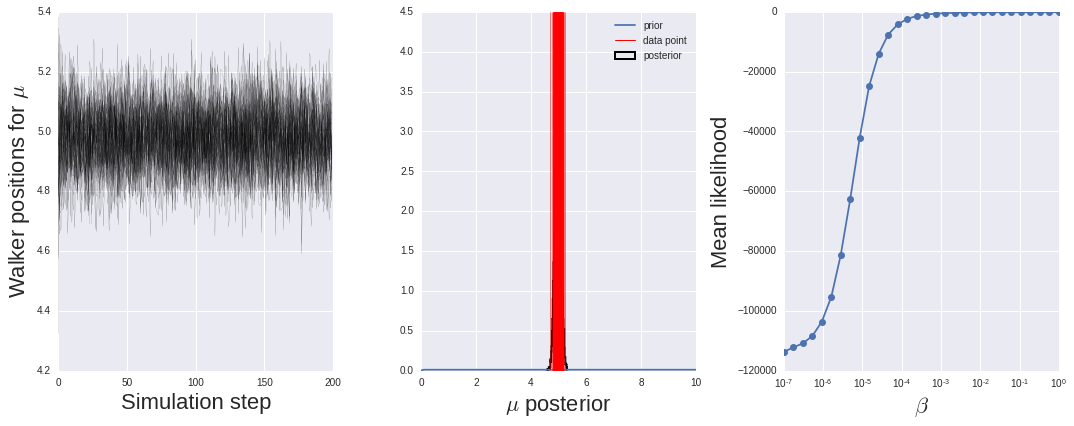

Z = 6.799e-43 +/- 6.118e-43


In [20]:
run('unif', 0, 100, x=np.random.normal(5, 0.1, 100), betamin=-7)